In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('C:/Users/yana/3/retail_train.csv')
item_features = pd.read_csv('C:/Users/yana/3/product.csv')
user_features = pd.read_csv('C:/Users/yana/3/hh_demographic.csv')

ITEM_COL = 'item_id'
USER_COL = 'user_id'
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [3]:
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [4]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [5]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\yana\utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


In [6]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

In [7]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [8]:
ACTUAL_COL = 'actual'
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

In [9]:
# N = Neighbors
N_PREDICT = 50

In [10]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()
        
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [11]:
result_eval_matcher['cosine_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_cosine_recommendations(x, N=50))
result_eval_matcher['tfidf_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_tfidf_recommendations(x, N=50))
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [12]:
result_eval_matcher['popular_items'] = result_eval_matcher[USER_COL].apply(lambda x: recommender._extend_with_top_popular([], N=50))

In [13]:
TOPK_RECALL = 50

In [14]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('cosine_rec', 0.06781909881936234),
 ('tfidf_rec', 0.06781062019474052),
 ('own_rec', 0.06140888114964771),
 ('als_rec', 0.043531922714650416),
 ('popular_items', 0.037658978350251025),
 ('sim_item_rec', 0.029964994190787065),
 ('sim_user_rec', 0.006590977430186753)]

Наибольший recall дал cosine recommender. Own recommendations+top_popular(extend with top popular) на 3м месте, отдельно top popular - на 5м

### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500} 

In [15]:
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=50))
    k = [10, 20, 50, 100, 200, 500]
    recall= [df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=i), axis=1).mean() for i in k]
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(k, recall) 
    ax.set_xlabel('k')
    ax.set_ylabel('recall')
    return recall

[0.02663471072318868,
 0.03979608995142128,
 0.06781909881936234,
 0.06781909881936234,
 0.06781909881936234,
 0.06781909881936234]

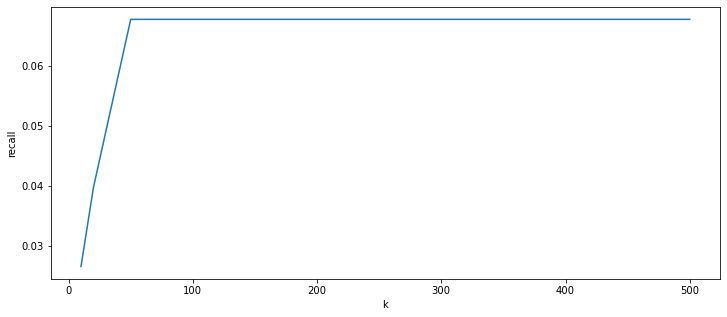

In [16]:
evalRecall(result_eval_matcher, USER_COL, recommender.get_cosine_recommendations)

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Наибольший recall достигается на k = 50, далее не растет. Поэтому кажется оптимальным взять значение 50

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [17]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [18]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [19]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,950202
0,2070,944588
0,2070,10198378


In [20]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [21]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [22]:
df_ranker_train.target.value_counts()

0.0    98842
1.0     7500
Name: target, dtype: int64

In [23]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')

In [24]:
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,950202,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,10198378,0.0,69,GROCERY,Private,DOG FOODS,DRY DOG VALUE (PET PRIDE/KLR/G,50 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,1082955,1.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 20PK&24PK CAN CARB,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [25]:
cat_feats = df_ranker_train.columns[3:].tolist()

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

#### New features

Фичи user_id: Кол-во покупок в каждой категории, среднее кол-во покупок в мeсяц

In [31]:
df_features = data.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(df_features.groupby(['user_id', 'department'])['quantity'].sum().reset_index(), on=['user_id', 'department'], how='left')
df_ranker_train = df_ranker_train.rename(columns={'quantity':'q-ty_per_cat'})
max_month = df_features['week_no'].max()//4
df_ranker_train = df_ranker_train.merge(df_features.groupby('user_id')['quantity'].sum()/max_month, on=['user_id'], how='left')
df_ranker_train = df_ranker_train.rename(columns={'quantity':'q-ty_per_month'})

**Фичи item_id**:
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории

In [32]:
df_features['price'] = df_features['sales_value'] / (np.maximum(df_features['quantity'], 1))
df_ranker_train = df_ranker_train.merge(df_features.groupby('item_id')['price'].mean(), on='item_id', how='left')
df_ranker_train = df_ranker_train.rename(columns={'price':'item_price'})
df_ranker_train = df_ranker_train.merge(df_features.groupby('department')['price'].mean(), on='department', how='left')
df_ranker_train = df_ranker_train.rename(columns={'price':'dept_avg_price'})
df_ranker_train['price_ratio'] = df_ranker_train['item_price'] / df_ranker_train['dept_avg_price']

**Фичи пары user_id - item_id**
   Кол-во покупок юзером конкретной категории / Кол-во покупок всеми юзерами конкретной категории, (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
   

In [33]:
df_ranker_train = df_ranker_train.merge(df_features.groupby('department')['quantity'].sum(), on='department', how='left')
df_ranker_train = df_ranker_train.rename(columns={'quantity':'total_q-ty_cat'})
df_ranker_train['user_to_total_q-ty'] = df_ranker_train['q-ty_per_cat'] / df_ranker_train['total_q-ty_cat']
df_ranker_train['avg_price_minus_item_price'] = df_ranker_train['dept_avg_price'] - df_ranker_train['item_price']

In [34]:
df_ranker_train.head(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,household_size_desc,kid_category_desc,q-ty_per_cat,q-ty_per_month,item_price,dept_avg_price,price_ratio,total_q-ty_cat,user_to_total_q-ty,avg_price_minus_item_price
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,1,None/Unknown,24.0,5294.130435,3.796408,3.899216,0.973634,62022,0.000387,0.102808
1,2070,950202,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,1,None/Unknown,24.0,5294.130435,3.715172,3.899216,0.952800,62022,0.000387,0.184044
2,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,...,1,None/Unknown,190.0,5294.130435,3.599726,2.981432,1.207381,137379,0.001383,-0.618294
3,2070,10198378,0.0,69,GROCERY,Private,DOG FOODS,DRY DOG VALUE (PET PRIDE/KLR/G,50 LB,45-54,...,1,None/Unknown,2216.0,5294.130435,9.963510,2.062880,4.829902,2025562,0.001094,-7.900630
4,2070,1082955,1.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 20PK&24PK CAN CARB,12 OZ,45-54,...,1,None/Unknown,2216.0,5294.130435,7.523333,2.062880,3.647005,2025562,0.001094,-5.460453


In [35]:
df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106342 entries, 0 to 106341
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     106342 non-null  int64  
 1   item_id                     106342 non-null  int64  
 2   target                      106342 non-null  float64
 3   manufacturer                106342 non-null  int64  
 4   department                  106342 non-null  object 
 5   brand                       106342 non-null  object 
 6   commodity_desc              106342 non-null  object 
 7   sub_commodity_desc          106342 non-null  object 
 8   curr_size_of_product        106342 non-null  object 
 9   age_desc                    39480 non-null   object 
 10  marital_status_code         39480 non-null   object 
 11  income_desc                 39480 non-null   object 
 12  homeowner_desc              39480 non-null   object 
 13  hh_comp_desc  

In [36]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train['target']
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [37]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     num_leaves = 64,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [38]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [39]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [40]:
TOPK_PRECISION = 5

In [41]:
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [42]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [43]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [44]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

C:\Users\yana\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


('reranked_own_rec', 0.16649159663865393)
('own_rec', 0.135140463282404)


Precision при использовании 2х-уровневой модели вырос